In [1]:
# importing some basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import os
import gc # garbage collector to free GPU memory
# from tqdm.notebook import tqdm # visualization of progress in loops
from tqdm import tqdm # visualization of progress in loops


In [2]:
# loading kaggle API to download the data set needed
import kaggle

dataset_name= "micropcb-images.zip" # name of the zip-file, which is getting downloaded from kaggle
dataset_base_folder= "/media/igor/FEM-storage-Linux/Phython_project_datasets"
dataset_destination= dataset_base_folder+ "/PCB_defects_dataset/"
notebook_location= "/media/igor/Linux_drive-A/Eigene_Dateien/Python_project/pythonProject-007_GPGPUs"

check_zip=0  # control variable set= 1 if zip-file already has been downloaded
check_data=0 # control variable set= 1 if dataset already has been extracted from zip-file

print("1.1 looping through the notebook directory to check if the dataset has been downloaded already")
for file_path in os.listdir(notebook_location): # looping through notebook directory to check if dataset has been downloaded already
    print(file_path)
    if os.path.isfile(os.path.join(notebook_location, file_path)):
        if file_path == dataset_name: # compare the current file name with the deisred one
            print("*** dataset exists ***")
            check_zip=1
            break
if check_zip==0:
    print("\n".join(("dataset is not yet found in notebook directory", "checking dataset destination for extracted files...")))

print("2.1 checking if dataset has been extracted already to file destination")
for file_path in os.listdir(dataset_base_folder): # looping through the file destination in order to check if they have been extracted already
    if os.path.isdir(os.path.join(dataset_base_folder, file_path)):
        print(file_path)
        if file_path==dataset_destination.split("/")[-2]:
            print("*** files are already extracted from zip-file ***")
            check_data=1
if check_data==0:
    print("\n".join(("dataset is not yet found in file destination", "files are now either extracted or downloaded first and then extracted to its destination")))


# downloading the dataset from kaggle
if check_zip==0 and check_data==0:
    print("2.2 start downloading the dataset from kaggle")
    # !kaggle datasets download -d dataset_lacation
    check_zip=1

# generating a folder on the local machine and unzipping the files
if check_data==0:
    print("2.3 generating the file destination folder: ", dataset_destination)
    # os.makedirs(dataset_destination, exist_ok=True)

# unzipping the files
if check_zip==1 and check_data==0:
    print("2.4 extracting the dataset to its file destination")
    # !unzip micropcb-images.zip -d /media/igor/FEM-storage-Linux/Phython_project_datasets/PCB_defects_dataset
    check_data=1

# remoev zip-file after extracting the data
if check_zip==1 and check_data==1:
    print("2.5 removing the zip-file from notebook directory to free disk space")
    #os.remove(dataset_name) # the zip-file needs to be in the same folder as the notebook



1.1 looping through the notebook directory to check if the dataset has been downloaded already
007_GPGPU_pyTorch_1st_steps_NeuralNetworks.ipynb
.ipynb_checkpoints
007_GPGPU_1st_steps.ipynb
007_GPGPU_2nd_steps.ipynb
007_GPGPU_3rd_numba_arrays_for_ebay_2024.ipynb
007_GPGPU_3rd_steps_torchQuad_solving_integrals.ipynb
007_GPGPU_dual_utilization_examples.ipynb
007_GPGPU_ideal_gas_law.ipynb
007_GPGPU_kaggle_Ariel_dataset_001.ipynb
007_GPGPU_PCB_classification_Kaggle_data-set.ipynb
007_GPGPU_PCB_classification_Kaggle_data-set_002.ipynb
007_GPGPU_PCB_classification_Kaggle_data-set_003.ipynb
007_GPGPU_PCB_classification_Kaggle_data-set_multi-node-dask.ipynb
007_GPGPU_random_forest_on_GPU-node.ipynb
007_GPGPU_sequential_network.ipynb
007_GPGPU_time_forecasting_bike_rental_sklearn.ipynb
007_GPGPU_time_forecasting_bike_sharing_sklearn-dataset.ipynb
comp_Confusion_Matrix.pdf
cv3_best_estimators_and_scores_3bit.csv
cv3_best_estimators_and_scores_4bit.csv
cv3_Confusion_Matrix_3bit.pdf
cv3_Confusion_M

In [3]:
# defining some basic settings
if check_data==1:
    print("dataset location is on SSD")
    directory_settings= dataset_destination
else:
    print("dataset location is on HDD")
    directory_settings= "/media/igor/Linux_drive-A/Eigene_Dateien/Python_project/pythonProject-007_GPGPUs/data-sets/PCB_dataset_defects/"
# directory_settings= "/home/igor/Eigene_Dateien/Python_project/pythonProject-007_GPGPUs/data-sets/PCB_dataset_defects/"

directory_train= directory_settings + "train_coded/train_coded"
directory_test=  directory_settings + "test_coded/test_coded"



dataset location is on SSD


In [4]:
#some helper-functions

# ::::::::::::::::::::::::::::::::::::::::::::::::::::
# reading a folder and returning its file names
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
def file_names(location):
    return os.listdir(location)

# ::::::::::::::::::::::::::::::::::::::::::::::::::::
# generating a test and training DataFrame
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
def df_gen(_type):
    DataFrame_gen= 0
    for i, name in enumerate(file_names(directory_settings)):
        print("currently checking: ", name)
        if (name[-3:]== "csv") & (DataFrame_gen==0) & (name.split("_")[0]==_type):
            print("generating DataFrame....")
            df= pd.read_csv(directory_settings + name)
            DataFrame_gen=1
            continue
        if (name[-3:]== "csv") & (DataFrame_gen==1) & (name.split("_")[0]==_type):
            print(f"...adding {name} to my DataFrame ")
            df_temp= pd.read_csv(directory_settings + name)
            df_temp=df_temp.drop("Image", axis=1)
            df= pd.concat([df, df_temp], axis=1)
        else:
            print("jumping to next file...")
            continue
    return df

# ::::::::::::::::::::::::::::::::::::::::::::::::::::
# getting some additional info from the file-name codings
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
def dummy_gen(df, array, char0, char1, char2, char3):
    for i, name in enumerate(array):
        char= vars()["char"+ str(i)] # changing the character dictianory to the ones supplied above
        df[name]= df["Image"].apply(lambda x: char[x[i]])

    return df

# ::::::::::::::::::::::::::::::::::::::::::::::::::::
# ::::::::::::::: garbage collector ::::::::::::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
'''https://github.com/rapidsai/cuml/issues/5769'''
'''     thanks to: immanuelazn     '''
class GarbageCollector(): # BaseEstimator, TransformerMixin
    # this will free GPU memory after each itereation in GridSearchCV
    def __init__(self):
        pass
    def fit(self, X, y = None):
        gc.collect()
        return self
    def transform(self, X):
        gc.collect()
        return X


# ::::::::::::::::::::::::::::::::::::::::::::::::::::
# :::::::::::::: background detection ::::::::::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
def background(img, threshold, pixel): # common values threshold= 160, pixel=35
    # imArray= cv2.imread(img)
    # color conversion
    imArray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # adaptive background definition of the Gray-scale image
    return cv2.adaptiveThreshold(imArray, threshold, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,pixel,5)



In [5]:
# loading my definitions into a DataFrame
df_train= df_gen("train")
df_test=  df_gen("test")

# changing two identical column names
df_train.columns= ['Image', 'Angle', 'PCB_Left', 'PCBTop', 'PCB_Width', 'PCB_Height',
                   'Ratio_of_T-2-B_Edge_Length', 'Img_Width','Img_Height']
df_test.columns= ['Image', 'Angle', 'PCB_Left', 'PCBTop', 'PCB_Width', 'PCB_Height',
                  'Ratio_of_T-2-B_Edge_Length', 'Img_Width','Img_Height']

# reverse engineering the file-name-coded specs
# origin is the read-me text file
_1st_char= {"A": "Raspberry Pi A+", "B": "Arduino Mega 2560 (Blue)", "C":"Arduino Mega 2560 (Black)", 
                "D": "Arduino Mega 2560 (Black and Yellow)", "E": "Arduino Due", "F": "Beaglebone Black",
                "G": "Arduino Uno (Green)", "H": "Raspberry Pi 3 B+", "I": "Raspberry Pi 1 B+", 
                "J": "Arduino Uno Camera Shield", "K": "Arduino Uno (Black)", "L": "Arduino Uno WiFi Shield",
                "M": "Arduino Leonardo"}
char_1= {"A": 0, "B": 1, "C":2, "D": 3, "E": 4, "F": 5,"G": 6, "H": 7, "I": 8,"J": 9, "K": 10, "L": 11,"M": 12}
_2nd_char= {"A": "Wide left rotation", "B": "Shallow left rotation", "C": "Neutral rotation",
                "D": "Shallow right rotation", "E": "Wide right rotation"}

_3rd_char= {"A": "12 inches left of the camera position", "B": "6 inches left of the camera position",
                "C": "centered horizontally relative to the camera", "D": "6 inches right of the camera position",
                "E": "12 inches right of the camera position"}
_4th_char= _3rd_char
_5th_char= {"1": "Images numbered 1-4 are train images", "2": "Images numbered 1-4 are train images",
                "3": "Images numbered 1-4 are train images", "4": "Images numbered 1-4 are train images",
                "5": "Images numbered 5 are test images"}
char_def= ["model", "totation_type", "x-coord._capture", "y-coord._capture"]


print("including the specs from the file-name-coding into my DataFrame")
df_train= dummy_gen(df_train, char_def, _1st_char, _2nd_char, _3rd_char, _4th_char)
df_test=  dummy_gen(df_test, char_def, _1st_char, _2nd_char, _3rd_char, _4th_char)

print("::::::::::::::::::::::::::::::::")
print(":::::::::  finished  :::::::::::")
print("::::::::::::::::::::::::::::::::")

currently checking:  capture_surface_illustration.jpg
jumping to next file...
currently checking:  log_reg_4bit_model.pkl
jumping to next file...
currently checking:  rand_forest_4bit_model.pkl
jumping to next file...
currently checking:  README.txt
jumping to next file...
currently checking:  svm_4bit_model.pkl
jumping to next file...
currently checking:  svm_lin_4bit_model.pkl
jumping to next file...
currently checking:  test_angles.csv
jumping to next file...
currently checking:  test_bboxes.csv
jumping to next file...
currently checking:  test_coded
jumping to next file...
currently checking:  test_ratio_top_to_bottom.csv
jumping to next file...
currently checking:  test_sizes.csv
jumping to next file...
currently checking:  train_angles.csv
generating DataFrame....
currently checking:  train_bboxes.csv
...adding train_bboxes.csv to my DataFrame 
currently checking:  train_coded
jumping to next file...
currently checking:  train_ratio_top_to_bottom.csv
...adding train_ratio_top_to_

In [6]:
# get some dummy values from Pandas
df_train_dummy= pd.get_dummies(df_train.drop("Image", axis=1), drop_first=True)
df_train_dummy["Image"]= df_train["Image"]
df_test_dummy=  pd.get_dummies(df_test.drop("Image", axis=1), drop_first=True)
df_test_dummy["Image"]= df_test["Image"]

df_train_dummy.head()

print("::::::::::::::::::::::::::::::::")
print(":::::::::  finished  :::::::::::")
print("::::::::::::::::::::::::::::::::")

::::::::::::::::::::::::::::::::
:::::::::  finished  :::::::::::
::::::::::::::::::::::::::::::::


In [7]:
# :::::::::::::::::::::::::::::::::::::::::::::::::::::::
# ::::::::::::::: dictionary generation :::::::::::::::::
# :::::::::::::::::::::::::::::::::::::::::::::::::::::::

print("generating file locations for my train dataset")
file_names_train, file_names_test = np.array([]) ,np.array([])
pbar = tqdm(file_names(directory_train), total=len(file_names(directory_train)))
for i, img_name in enumerate(pbar):
    file_names_train= np.append(file_names_train, directory_train+ "/"+ file_names(directory_train)[i])

    
print("generating file locations for my test dataset")
pbar = tqdm(file_names(directory_test), total=len(file_names(directory_test)))
for i, img_name in enumerate(pbar):
    file_names_test= np.append(file_names_test, directory_test+ "/"+ file_names(directory_test)[i])


generating file locations for my train dataset


100%|██████████████████████████████████████| 6500/6500 [00:35<00:00, 183.89it/s]


generating file locations for my test dataset


100%|██████████████████████████████████████| 1625/1625 [00:02<00:00, 660.80it/s]


In [ ]:
# :::::::::::::::::::::::::::::::::::::::::::::::::::::::
# :::::::::::::::: some exploratory DA ::::::::::::::::::
# :::::::::::::::::::::::::::::::::::::::::::::::::::::::

print("analizing image dimensions and total pixel count for train DS")

picture_stats_train, picture_stats_test= np.array([]), np.array([])

# train data set (DS)
pbar = tqdm(file_names_train, total=len(file_names_train))
for img_name in pbar:
    image_data= cv2.imread(img_name)
    X, y = image_data.shape[0], image_data.shape[1]
    picture_stats_train= np.append(picture_stats_train, [X, y, X* y])

picture_stats_train= picture_stats_train.reshape(len(file_names_train), 3)
df_stats_train= pd.DataFrame(picture_stats_train, columns=["pixel_X", "pixel_y", "total_pixel"])

print("analizing image dimensions and total pixel count for test DS")
# test data set (DS)
pbar = tqdm(file_names_test, total=len(file_names_test))
for img_name in pbar:
    image_data= cv2.imread(img_name)
    X, y = image_data.shape[0], image_data.shape[1]
    picture_stats_test= np.append(picture_stats_test, [X, y, X* y])

picture_stats_test= picture_stats_test.reshape(len(file_names_test), 3)
df_stats_test= pd.DataFrame(picture_stats_test, columns=["pixel_X", "pixel_y", "total_pixel"])

# visualization of the obtained information about the pictures in my data set
fig, axn= plt.subplots(1,2, figsize=(10,5))
sns.pointplot(data=df_stats_train, x= 1, y="pixel_X", errorbar= "sd", label= "pixel count X-axis (train DS)", ax= axn[0])
sns.pointplot(data=df_stats_train, x= 2, y="pixel_y", errorbar= "sd", label= "pixel count y-axis (train DS)", ax= axn[0])
sns.histplot(data=df_stats_train, x="total_pixel", label= "picture resolution (train DS)", ax= axn[1])

sns.pointplot(data=df_stats_test, x= 1.2, y="pixel_X", errorbar= "sd", marker="D", label= "pixel count X-axis (test DS)", ax= axn[0])
sns.pointplot(data=df_stats_test, x= 2.2, y="pixel_y", errorbar= "sd", marker="D", label= "pixel count y-axis (test DS)", ax= axn[0])
sns.histplot(data=df_stats_test, x="total_pixel", label= "picture resolution (test DS)", ax= axn[1])

[axn[i].legend() for i in range(2)]
[axn[i].grid(True) for i in range(2)]
fig.tight_layout()
plt.show()


In [ ]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::::
# :::: visualization of my transformed test image ::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::::

img_size= 64 # 64
pixel= 3
threshold= 165

image_loc= file_names_train[1]
print("file name to load: \n", image_loc)

img= cv2.imread(image_loc)
image_red= cv2.resize(img, (img_size, img_size))

imArray= cv2.cvtColor(image_red, cv2.COLOR_BGR2GRAY)
# adaptive background definition of the Gray-scale image
imArray= cv2.adaptiveThreshold(imArray, threshold, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,pixel,5)
tmp1= cv2.createBackgroundSubtractorMOG2().apply(imArray)
tmp2= imArray
tmp3= cv2.createBackgroundSubtractorKNN().apply(image_red)

fig, axn= plt.subplots(2,2, figsize=(10,10))
axn[0,0].imshow(tmp1, cmap= "gray")
axn[0,1].imshow(tmp2, cmap= "gray")
axn[1,0].imshow(img, cmap= "gray")
axn[1,1].imshow(image_red, cmap= "gray")

plt.show()

In [8]:
# :::::::::::::::::::::::::::::::::::::::::::
# this is with background subtraction methode
# :::::::::::::::::::::::::::::::::::::::::::

import cupy as cp
import cudf

# **************************
verbose_01= 1 # can be used to enable an additional contrast picture if set= 1
# **************************

# stagging my cropped image together with my wavelet transforemd data into a numpy array for model-training
versions = 13 # dataset comprises of 13 differenct PCBs
lim_train= 500* versions -1  # not the full size yet: len(file_names(directory_train))
lim_test = 125* versions -1  # not the full size yet: len(file_names(directory_test))
if verbose_01==1: 
    img_size= 64
    bit= 4
else: 
    img_size=76
    bit=3
X_train, y_train= [], []
X_test, y_test= [], []

X_train_cu, y_train_cu= cp.array([]), cp.array([])
X_test_cu, y_test_cu= cp.array([]), cp.array([])

pbar = tqdm(file_names_train, total=lim_train)
for num,training_image in enumerate(pbar):
    # img= cv2.imread(training_image)
    img=cv2.resize(cv2.imread(training_image), (img_size,img_size))
    if img is None:
        continue
    scalled_raw_img = img
    imArray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    scalled_img_haar= cv2.adaptiveThreshold(imArray, 165, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,3,5)
    # scalled_img_haar= cv2.resize(img_haar, (img_size,img_size))
    if verbose_01==1: combined_img= np.vstack((scalled_raw_img.reshape(img_size*img_size*3,1), scalled_img_haar.reshape(img_size*img_size,1)))
    else: combined_img= scalled_raw_img.reshape(img_size*img_size*3,1)
    X_train.append(combined_img)
    y_train.append(df_train["Image"].apply(lambda x: char_1[x[0]])[num]) #y_train.append(df_train["Image"].apply(lambda x: _1st_char[x[0]])[num])
    # CUDA version of numpy for GPU inferences
    X_train_cu= cp.append(X_train_cu, combined_img)
    if num==lim_train: break

# simple conversion to CuPy
y_train_cu= cudf.Series(y_train).to_cupy()

# reshaping my training data
X_train= np.array(X_train).reshape(len(X_train),int(img_size**2* bit)).astype(np.int8) #.astype(float), with astype(int) memory gets saved
X_train_cu= cp.array(X_train_cu).reshape(num+1, int(img_size**2* bit))
print("the shape of the data in my train dataset is: ", X_train.shape)


pbar = tqdm(file_names_test, total=lim_test)
for num,training_image in enumerate(pbar):
    # img= cv2.imread(training_image)
    img= cv2.resize(cv2.imread(training_image), (img_size,img_size))
    if img is None:
        continue
    scalled_raw_img = img
    imArray= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    scalled_img_haar= cv2.adaptiveThreshold(imArray, 165, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,3,5)
    # scalled_img_haar= cv2.resize(img_haar, (img_size,img_size))
    if verbose_01==1: combined_img= np.vstack((scalled_raw_img.reshape(img_size*img_size*3,1), scalled_img_haar.reshape(img_size*img_size,1)))
    else: combined_img= scalled_raw_img.reshape(img_size*img_size*3,1)
    X_test.append(combined_img)
    y_test.append(df_test["Image"].apply(lambda x: char_1[x[0]])[num])
    # CUDA version of numpy for GPU infenrences
    X_test_cu= cp.append(X_test_cu, combined_img)
    if num==lim_test: break

# simple conversion to CuPy
y_test_cu= cudf.Series(y_test).to_cupy()
        
# reshaping my training data
X_test= np.array(X_test).reshape(len(X_test),int(img_size**2 * bit)).astype(np.int8) # .astype(float), with astype(int) memory gets saved
X_test_cu= cp.array(X_test_cu).reshape(num+1, int(img_size**2* bit))
print("the shape of the data in my test dataset is: ", X_test.shape)

print("::::::::::::::::::::::::::::::::")
print(":::::::::  finished  :::::::::::")
print("::::::::::::::::::::::::::::::::")

100%|███████████████████████████████████████| 6499/6499 [03:23<00:00, 31.93it/s]


the shape of the data in my train dataset is:  (6500, 16384)


100%|███████████████████████████████████████| 1624/1624 [00:41<00:00, 39.16it/s]

the shape of the data in my test dataset is:  (1625, 16384)
::::::::::::::::::::::::::::::::
:::::::::  finished  :::::::::::
::::::::::::::::::::::::::::::::


In [9]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# definition of the classifiers to be used with CUDA
# ::::::::::::::::::::::::::::::::::::::::::::::::::
#   this attempt needs a Nvidia Volta Series GPU
# ::::::::::::::::::::::::::::::::::::::::::::::::::
from cuml.pipeline import make_pipeline as cumake_pipeline
from cuml.linear_model import LogisticRegression as cuLR
from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.svm import svc as cuSVM
from cuml.svm import LinearSVC as cuLinSVM

import torch
print("total available CUDA devices: ", torch.cuda.device_count())
print("active CUDA divice: ", torch.cuda.get_device_name())

model_params_cu={
    "rand_forest": {"model": cuRFC(random_state= 1984),
                     "params": {"randomforestclassifier__n_estimators": [40, 50, 60, 70, 80]
                               }},
    "svm": {"model": cuSVM.SVC(random_state= 1984),
           "params": {"svc__C": [1,3,5,7,10],
                      "svc__kernel": ["rbf"]
                     }},
    "svm_lin": {"model": cuLinSVM(max_iter=5000),
                   "params": {"linearsvc__C": [1,5,10,20,30]
                             }},
    "log_reg": {"model": cuLR(max_iter=5000),
                           "params": {"logisticregression__C": [30, 40, 50, 60, 80, 100, 120]
                                     }}
}



total available CUDA devices:  3
active CUDA divice:  Tesla V100-PCIE-16GB
[I] [18:35:12.698727] Unused keyword parameter: random_state during cuML estimator initialization


/home/igor/anaconda3/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


In [11]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# ::::::::: looping through the classifiers ::::::::
# :::::::::       will run on the GPU       ::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::


# generating a pipeline to identify the best performing classification
from timeit import default_timer as timer
from cuml.model_selection import GridSearchCV as cuGridSearchCV
from cuml.preprocessing import StandardScaler as cuStandardScaler

start= timer()

scores_cu= []
best_estimators_cu= {}

# use "model_params_cu" for GPU utilization
start= timer()
for algo, mp in model_params_cu.items():
    print(f"currently building a model based on {mp['model']} with the following paramters: \n {mp['params']}")
    pipe_cu= cumake_pipeline(GarbageCollector(),cuStandardScaler(), mp["model"])
    clf= cuGridSearchCV(pipe_cu, mp["params"], cv=5, return_train_score=False) # cv= 5, n_jobs=2
    clf.fit(X_train_cu, y_train_cu.get())
    scores_cu.append({"model": mp["model"],
        "best_score": clf.best_score_,
        "best_params": clf.best_params_})
    best_estimators_cu[algo]= clf.best_estimator_
end= timer()

print(":::::::::::::::::::::::::::::::") # it takes about 18 minutes with a single V100 and cv= 3 | 32 minuts with cv= 5
print(f"time it took to find the best params by using the GPU: {(end-start)/60:.3f} minutes")
print(":::::::::::::::::::::::::::::::")

df_scores_cu= pd.DataFrame(scores_cu, columns=["model", "best_score", "best_params"])
df_scores_cu



currently building a model based on RandomForestClassifier() with the following paramters: 
 {'randomforestclassifier__n_estimators': [40, 50, 60, 70, 80]}


/home/igor/anaconda3/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/igor/anaconda3/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/igor/anaconda3/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


currently building a model based on SVC() with the following paramters: 
 {'svc__C': [1, 3, 5, 7, 10], 'svc__kernel': ['rbf']}
currently building a model based on LinearSVC() with the following paramters: 
 {'linearsvc__C': [1, 5, 10, 20, 30]}
currently building a model based on LogisticRegression() with the following paramters: 
 {'logisticregression__C': [30, 40, 50, 60, 80, 100, 120]}
:::::::::::::::::::::::::::::::
time it took to find the best params by using the GPU: 31.778 minutes
:::::::::::::::::::::::::::::::


,model,best_score,best_params
0,RandomForestClassifier(),0.862615,{'randomforestclassifier__n_estimators': 80}
1,SVC(),0.873846,"{'svc__C': 1, 'svc__kernel': 'rbf'}"
2,LinearSVC(),0.849846,{'linearsvc__C': 1}
3,LogisticRegression(),0.852615,{'logisticregression__C': 40}


In [29]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# definition of the classifiers to be used with CUDA
# ::::::::::::::::::::::::::::::::::::::::::::::::::
#   this attempt needs a Nvidia Volta Series GPU
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::
#              refined hyper-parameters
# ::::::::::::::::::::::::::::::::::::::::::::::::::


print("total available CUDA devices: ", torch.cuda.device_count())
print("active CUDA divice: ", torch.cuda.get_device_name())

model_params_cu={
    "rand_forest": {"model": cuRFC(random_state= 1984),
                     "params": {"randomforestclassifier__n_estimators": [100, 120, 150, 300]
                               }},
    "svm": {"model": cuSVM.SVC(random_state= 1984),
           "params": {"svc__C": [0.6, 0.8, 0.9, 1],
                      "svc__kernel": ["rbf"]
                     }},
    "svm_lin": {"model": cuLinSVM(max_iter=5000),
                   "params": {"linearsvc__C": [0.9, 1, 1.1, 1.3, 1.5]
                             }},
    "log_reg": {"model": cuLR(max_iter=5000),
                           "params": {"logisticregression__C": [5, 10, 15, 20]
                                     }}
}



total available CUDA devices:  3
active CUDA divice:  Tesla V100-PCIE-16GB


In [30]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# ::::::::: looping through the classifiers ::::::::
# :::::::::       will run on the GPU       ::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::
#              refined hyper-parameters
# ::::::::::::::::::::::::::::::::::::::::::::::::::

start= timer()

scores_cu= []
best_estimators_cu= {}

# use "model_params_cu" for GPU utilization
start= timer()
for algo, mp in model_params_cu.items():
    print(f"currently building a model based on {mp['model']} with the following paramters: \n {mp['params']}")
    pipe_cu= cumake_pipeline(GarbageCollector(),cuStandardScaler(), mp["model"])
    clf= cuGridSearchCV(pipe_cu, mp["params"], cv=5, return_train_score=False) # cv= 5, n_jobs=2
    clf.fit(X_train_cu, y_train_cu.get())
    scores_cu.append({"model": mp["model"],
        "best_score": clf.best_score_,
        "best_params": clf.best_params_})
    best_estimators_cu[algo]= clf.best_estimator_
end= timer()

print(":::::::::::::::::::::::::::::::") # it takes about 60 minutes with a single V100 and cv=5
print(f"time it took to find the best params by using the GPU: {(end-start)/60:.3f} minutes")
print(":::::::::::::::::::::::::::::::")

df_scores_cu= pd.DataFrame(scores_cu, columns=["model", "best_score", "best_params"])
df_scores_cu



currently building a model based on RandomForestClassifier() with the following paramters: 
 {'randomforestclassifier__n_estimators': [100, 120, 150, 300]}


/home/igor/anaconda3/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/igor/anaconda3/lib/python3.12/site-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)
/home/igor/anaconda3/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


currently building a model based on SVC() with the following paramters: 
 {'svc__C': [0.6, 0.8, 0.9, 1], 'svc__kernel': ['rbf']}
currently building a model based on LinearSVC() with the following paramters: 
 {'linearsvc__C': [0.9, 1, 1.1, 1.3, 1.5]}
currently building a model based on LogisticRegression() with the following paramters: 
 {'logisticregression__C': [5, 10, 15, 20]}
:::::::::::::::::::::::::::::::
time it took to find the best params by using the GPU: 37.624 minutes
:::::::::::::::::::::::::::::::


,model,best_score,best_params
0,RandomForestClassifier(),0.884000,{'randomforestclassifier__n_estimators': 300}
1,SVC(),0.876308,"{'svc__C': 0.8, 'svc__kernel': 'rbf'}"
2,LinearSVC(),0.848154,{'linearsvc__C': 1}
3,LogisticRegression(),0.855538,{'logisticregression__C': 5}


In [31]:
# :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
# quick export of the results for comparison reasons between runs
# :::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
df_scores_cu.to_csv(notebook_location+ "/cv5_best_estimators_and_scores_4bit_title.csv")

print("::::::::::::::::::::::::::::::::")
print(":::::::::  finished  :::::::::::")
print("::::::::::::::::::::::::::::::::")

::::::::::::::::::::::::::::::::
:::::::::  finished  :::::::::::
::::::::::::::::::::::::::::::::


In [ ]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# :::::::::: definition of the classifiers :::::::::
# ::::::::::      will run on the CPU      :::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::

from sklearn.pipeline import make_pipeline as make_pipeline
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC


model_params={
    "svm": {"model": SVC(random_state= 1984),
           "params": {"svc__C": [1,2,3,4,5], # 100,1000
                      "svc__kernel": ["rbf", "linear"]
                     }},
    "rand_forest": {"model": RFC(random_state= 1984),
                     "params": {"randomforestclassifier__n_estimators": [40, 50, 60, 80, 100, 150]
                               }},
    "log_reg": {"model": LR(max_iter=5000),
                           "params": {"logisticregression__C": [20, 30, 40, 50, 60]
                                     }}
}


In [ ]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# :::::::::: definition of the classifiers :::::::::
# ::::::::::      will run on the CPU      :::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::

from timeit import default_timer as timer
from sklearn.model_selection import GridSearchCV as GridSearchCV
from sklearn.preprocessing import StandardScaler as StandardScaler

scores= []
best_estimators= {}

# use "model_params" for CPU utilization
start= timer()
for algo, mp in model_params.items():
    print(f"currently building a model based on {mp['model']} with the following paramters: \n {mp['params']}")
    pipe= make_pipeline(StandardScaler(), mp["model"])
    clf= GridSearchCV(pipe, mp["params"], cv=5, return_train_score=False, n_jobs= -1) # n_jobs= -1 -> all core will be utilized
    clf.fit(X_train, y_train)
    scores.append({"model": mp["model"],
        "best_score": clf.best_score_,
        "best_params": clf.best_params_})
    best_estimators[algo]= clf.best_estimator_
end= timer()

print(":::::::::::::::::::::::::::::::")
print(f"time it took to find the best params by using the CPU: {(end-start):.3f}")
print(":::::::::::::::::::::::::::::::")

df_scores= pd.DataFrame(scores, columns=["model", "best_score", "best_params"])
df_scores


In [ ]:
# ::::::::::::::::::::::::::::::::
# ::::: results based on CPU :::::
# ::::::::::::::::::::::::::::::::
print(f"score achived by applying SVC to the train DS: {best_estimators['svm'].score(X_test, y_test):.3f}")
print(f"score achived by applying RF to the train DS: {best_estimators['rand_forest'].score(X_test, y_test):.3f}")
print(f"score achived by applying LR to the train DS: {best_estimators['log_reg'].score(X_test, y_test):.3f}")



In [33]:
# ::::::::::::::::::::::::::::::::
# ::::: results based on GPU :::::
# ::::::::::::::::::::::::::::::::

# all models trained
_class= ["svm", "svm_lin", "rand_forest", "log_reg"]

# storing the scoring-results based on the test DataFrame in a table
print("storing the results in a table....")
_precission=[[_class[i], best_estimators_cu[_class[i]].score(X_test_cu, y_test_cu)] for i in range(len(_class))]

# printing results for all models trained
[print(f"score achived by applying {_class[i]} to the train DS: {_precission[i][1]}") for i in range(len(_class))]


'''print(f"score achived by applying SVC to the train DS: {best_estimators_cu['svm'].score(X_test_cu, y_test_cu):.3f}")
print(f"score achived by applying LinSVC to the train DS: {best_estimators_cu['svm_lin'].score(X_test_cu, y_test_cu):.3f}")
print(f"score achived by applying RF to the train DS: {best_estimators_cu['rand_forest'].score(X_test_cu, y_test_cu):.3f}")
print(f"score achived by applying LR to the train DS: {best_estimators_cu['log_reg'].score(X_test_cu, y_test_cu):.3f}")'''


storing the results in a table....
score achived by applying svm to the train DS: 0.8683077096939087
score achived by applying svm_lin to the train DS: 0.891076922416687
score achived by applying rand_forest to the train DS: 0.8553845882415771
score achived by applying log_reg to the train DS: 0.8941538333892822


'print(f"score achived by applying SVC to the train DS: {best_estimators_cu[\'svm\'].score(X_test_cu, y_test_cu):.3f}")\nprint(f"score achived by applying LinSVC to the train DS: {best_estimators_cu[\'svm_lin\'].score(X_test_cu, y_test_cu):.3f}")\nprint(f"score achived by applying RF to the train DS: {best_estimators_cu[\'rand_forest\'].score(X_test_cu, y_test_cu):.3f}")\nprint(f"score achived by applying LR to the train DS: {best_estimators_cu[\'log_reg\'].score(X_test_cu, y_test_cu):.3f}")'

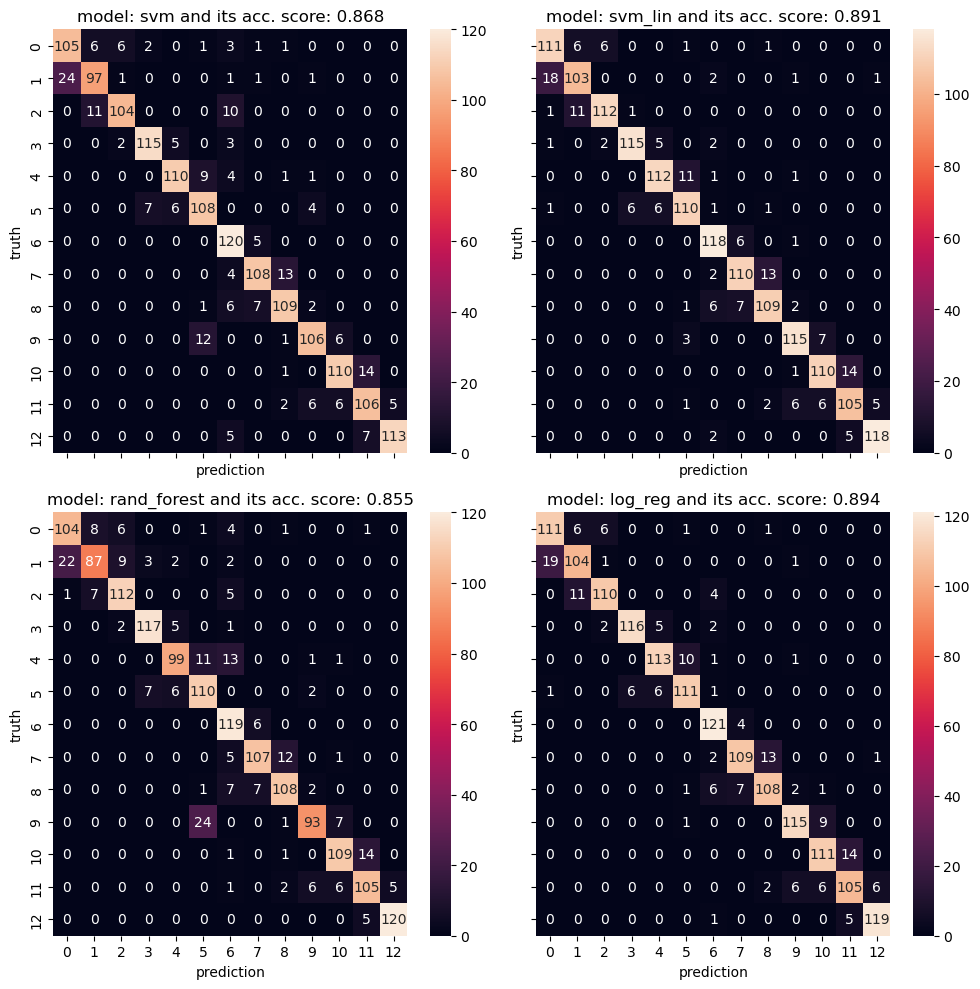

In [50]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# :::::::::: generation of confusino matrix ::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::


from sklearn.metrics import confusion_matrix as cm
import seaborn as sns

_class=["svm", "svm_lin", "rand_forest", "log_reg"]
# defining an array with the classifiers containing their best estimators
clf= [best_estimators_cu[_class[i]] for i in range(4)]

# looping throught the different classiffiers
y_predict= [clf[i].predict(X_test_cu) for i in range(4)]


# generating confucion matrices for the different classifies
cm_PCB= [cm(y_test, y_predict[i].get()) for i in range(4)]

fig, axm= plt.subplots(2,2, figsize= (10,10), sharex=True, sharey=True)

sns.heatmap(cm_PCB[0], annot=True, fmt= "g", ax= axm[0,0])
sns.heatmap(cm_PCB[1], annot=True, fmt= "g", ax= axm[0,1])
sns.heatmap(cm_PCB[2], annot=True, fmt= "g", ax= axm[1,0])
sns.heatmap(cm_PCB[3], annot=True, fmt= "g", ax= axm[1,1])

for i, ax in enumerate(axm.flat):
    # set common labels
    ax.set(xlabel= "prediction", ylabel= "truth")
    ax.set(title= f"model: {_class[i]} and its acc. score: {_precission[i][1]:.3f}") # set the plot titles to the model used
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    ax.label_outer()

fig.tight_layout()
plt.savefig(notebook_location+ "/cv5_Confusion_Matrix_4bit_title.pdf", bbox_inches="tight", transparent=True)
plt.show()


In [ ]:
# ::::::::::::::::::::::::::::::::::::::::::::::::::
# ::::::::::: exporting my optimzed models :::::::::
# ::::::::::::::::::::::::::::::::::::::::::::::::::

import pickle

# looping through all models defined and optimzed
[pickle.dump(clf[i], open(directory_settings+ _class[i]+"_4bit_model.pkl", "wb")) for i in range(int(len(_class)))]


In [ ]:
from numba import cuda

cuda.close()